In [6]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.auto import tqdm

In [7]:
class LeapMotionDataset(Dataset):
    def __init__(self, root_dir, seq_len=40, transform=None):
        """
        Dataset pour les données du Leap Motion

        Args:
            root_dir: Répertoire racine contenant les dossiers des personnes
            seq_len: Longueur de la séquence à utiliser (nombre de frames)
            transform: Transformations éventuelles
        """
        self.root_dir = root_dir
        self.seq_len = seq_len
        self.transform = transform
        self.sequences = []

        # Parcourir la structure de données
        person_folders = sorted(
            [
                f
                for f in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, f))
            ]
        )

        for person_id, person_folder in enumerate(person_folders):
            person_path = os.path.join(root_dir, person_folder)

            gesture_folders = sorted(
                [
                    f
                    for f in os.listdir(person_path)
                    if os.path.isdir(os.path.join(person_path, f))
                ]
            )
            for gesture_folder in gesture_folders:
                # Extraire l'ID du geste (g00 -> 0, g01 -> 1, etc.)
                if gesture_folder.startswith("g") and len(gesture_folder) >= 3:
                    try:
                        gesture_id = int(gesture_folder[1:3])
                    except ValueError:
                        continue

                    gesture_path = os.path.join(person_path, gesture_folder)

                    repetition_folders = sorted(
                        [
                            f
                            for f in os.listdir(gesture_path)
                            if os.path.isdir(os.path.join(gesture_path, f))
                        ]
                    )
                    for repetition_folder in repetition_folders:
                        try:
                            repetition_id = int(repetition_folder)
                        except ValueError:
                            continue

                        repetition_path = os.path.join(gesture_path, repetition_folder)
                        tracking_path = os.path.join(
                            repetition_path, "leap_motion", "tracking_data"
                        )

                        if os.path.exists(tracking_path):
                            json_files = sorted(
                                [
                                    f
                                    for f in os.listdir(tracking_path)
                                    if f.endswith("_js.json")
                                ]
                            )

                            if len(json_files) >= self.seq_len:
                                self.sequences.append(
                                    {
                                        "person_id": person_id,
                                        "gesture_id": gesture_id,
                                        "repetition_id": repetition_id,
                                        "json_files": [
                                            os.path.join(tracking_path, f)
                                            for f in json_files[: self.seq_len]
                                        ],
                                    }
                                )

    def __len__(self):
        return len(self.sequences)

    def extract_hand_features(self, json_data):
        """Extraire les caractéristiques essentielles de la main depuis le JSON"""
        features = []

        try:
            # Si les données contiennent une main droite
            if "right_hand" in json_data["frame"]:
                hand = json_data["frame"]["right_hand"]

                # Position de la paume (3 coordonnées)
                palm_pos = hand["palm_position"][:3]
                features.extend(palm_pos)

                # Direction et normale de la paume (6 coordonnées)
                features.extend(hand["direction"][:3])
                features.extend(hand["palm_normal"][:3])

                # Positions des articulations des doigts
                fingers = hand["fingers"]
                for finger_name in ["thumb", "index", "middle", "ring", "pinky"]:
                    if finger_name in fingers:
                        finger = fingers[finger_name]
                        for bone_name in [
                            "metacarpal",
                            "proximal",
                            "intermediate",
                            "distal",
                        ]:
                            if bone_name in finger["bones"]:
                                bone = finger["bones"][bone_name]
                                # Position de l'articulation (3 coordonnées)
                                features.extend(bone["next_joint"][:3])

            # Ajouter des zéros si les caractéristiques sont manquantes
            while len(features) < 64:  # Taille fixe des features
                features.append(0.0)

            return np.array(features[:64])  # Limiter à 64 caractéristiques

        except (KeyError, IndexError) as e:
            # Retourner un vecteur de zéros en cas d'erreur
            print(f"Erreur d'extraction: {e}")
            return np.zeros(64)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        hand_features = []

        for json_file in sequence["json_files"]:
            try:
                with open(json_file, "r") as f:
                    data = json.load(f)
                    features = self.extract_hand_features(data)
                    hand_features.append(features)
            except (json.JSONDecodeError, FileNotFoundError) as e:
                # En cas d'erreur, ajouter un vecteur de zéros
                print(f"Erreur de chargement {json_file}: {e}")
                hand_features.append(np.zeros(64))

        # Convertir en tensor
        hand_features = np.array(hand_features)
        hand_features = torch.tensor(hand_features, dtype=torch.float32)

        if self.transform:
            hand_features = self.transform(hand_features)

        return {
            "features": hand_features,
            "gesture_id": torch.tensor(sequence["gesture_id"], dtype=torch.long),
            "person_id": torch.tensor(sequence["person_id"], dtype=torch.long),
            "repetition_id": torch.tensor(sequence["repetition_id"], dtype=torch.long),
        }

In [8]:
class LeapMotionGCN(nn.Module):
    def __init__(self, input_features=64, hidden_dim=128, num_classes=12):
        super(LeapMotionGCN, self).__init__()

        # Couche d'embedding pour les caractéristiques de la main
        self.embedding = nn.Sequential(
            nn.Linear(input_features, hidden_dim), nn.ReLU(), nn.BatchNorm1d(hidden_dim)
        )

        # GRU bidirectionnel pour la séquence temporelle
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3,
        )

        # Attention
        self.attention = nn.Sequential(nn.Linear(hidden_dim * 2, 1), nn.Tanh())

        # Classification finale
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_features]
        batch_size, seq_len, _ = x.size()

        # Reshape pour l'embedding
        x_reshaped = x.reshape(batch_size * seq_len, -1)
        embedded = self.embedding(x_reshaped)

        # Retour à la forme séquentielle
        embedded = embedded.reshape(batch_size, seq_len, -1)

        # GRU
        gru_out, _ = self.gru(embedded)

        # Attention
        attn_weights = self.attention(gru_out).squeeze(-1)
        attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(-1)

        # Contexte pondéré par l'attention
        context = torch.sum(gru_out * attn_weights, dim=1)

        # Classification
        output = self.classifier(context)

        return output

In [9]:
# Préparation des données
train_dataset = LeapMotionDataset(root_dir="../leap_motion/train")
val_dataset = LeapMotionDataset(root_dir="../leap_motion/validation")
test_dataset = LeapMotionDataset(root_dir="../leap_motion/test")

print(f"Nombre total de séquences: {len(train_dataset)}")

# Ajouter ce code pour identifier le nombre de classes
unique_gestures = set()
for sequence in train_dataset.sequences:
    unique_gestures.add(sequence["gesture_id"])

num_classes = len(unique_gestures)
print(f"Nombre de classes uniques: {num_classes}")
print(f"IDs des classes: {sorted(list(unique_gestures))}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_dataset = DataLoader(test_dataset, batch_size=32)

# Modèle
model = LeapMotionGCN(input_features=64, hidden_dim=128, num_classes=13)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=5, factor=0.5
)

Nombre total de séquences: 962
Nombre de classes uniques: 13
IDs des classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [10]:
# Entraînement
def train(epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_acc = 0

    for epoch in tqdm(range(epochs), desc="Entraînement"):
        # Phase d'entraînement
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            features = batch["features"].to(device)
            targets = batch["gesture_id"].to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100.0 * correct / total

        # Phase de validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                features = batch["features"].to(device)
                targets = batch["gesture_id"].to(device)

                outputs = model(features)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_acc = 100.0 * correct / total

        # Affichage des métriques
        print(f"Epoch {epoch+1}/{epochs}:")
        print(
            f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%"
        )
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

        # Mise à jour du scheduler
        scheduler.step(val_loss)

        # Sauvegarde du meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_leap_model.pth")

    print(f"Meilleure précision de validation: {best_val_acc:.2f}%")


train(epochs=50)

Entraînement:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:
Train Loss: 2.3375, Train Acc: 30.35%
Val Loss: 1.8898, Val Acc: 42.08%
Epoch 2/50:
Train Loss: 1.4882, Train Acc: 62.99%
Val Loss: 1.6802, Val Acc: 40.27%
Epoch 3/50:
Train Loss: 0.7779, Train Acc: 77.65%
Val Loss: 0.7941, Val Acc: 70.59%
Epoch 4/50:
Train Loss: 0.4640, Train Acc: 81.91%
Val Loss: 0.6588, Val Acc: 76.92%
Epoch 5/50:
Train Loss: 0.3304, Train Acc: 87.11%
Val Loss: 1.5297, Val Acc: 49.32%
Epoch 6/50:
Train Loss: 0.4179, Train Acc: 86.80%
Val Loss: 1.4937, Val Acc: 51.58%
Epoch 7/50:
Train Loss: 0.4347, Train Acc: 83.58%
Val Loss: 1.4400, Val Acc: 54.75%
Epoch 8/50:
Train Loss: 0.3232, Train Acc: 88.67%
Val Loss: 1.5163, Val Acc: 55.20%
Epoch 9/50:
Train Loss: 0.3808, Train Acc: 87.42%
Val Loss: 1.1427, Val Acc: 69.23%
Epoch 10/50:
Train Loss: 0.2904, Train Acc: 89.19%
Val Loss: 1.4707, Val Acc: 58.37%
Epoch 11/50:
Train Loss: 0.3164, Train Acc: 92.31%
Val Loss: 0.5174, Val Acc: 82.81%
Epoch 12/50:
Train Loss: 0.3002, Train Acc: 88.05%
Val Loss: 0.7518, Val A

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np


def evaluate_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load("best_leap_model.pth"))
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(test_dataset, desc="Testing"):
            features = batch["features"].to(device)
            targets = batch["gesture_id"].to(device)

            # Get model predictions
            outputs = model(features)
            _, predicted = outputs.max(1)

            # Collect predictions and targets for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate overall accuracy
    accuracy = (np.array(all_preds) == np.array(all_targets)).mean() * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Get unique classes from predictions and targets
    unique_labels = sorted(set(all_targets).union(set(all_preds)))

    # Create gesture names for the classes present in the data
    gesture_names = [f"G{i}" for i in unique_labels]

    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_preds, labels=unique_labels)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()

    plt.xticks(np.arange(len(gesture_names)), gesture_names, rotation=45)
    plt.yticks(np.arange(len(gesture_names)), gesture_names)

    plt.tight_layout()
    plt.ylabel("True Gesture")
    plt.xlabel("Predicted Gesture")
    plt.show()

    # Print classification report with the correct labels
    print(
        classification_report(
            all_targets, all_preds, target_names=gesture_names, labels=unique_labels
        )
    )

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Erreur de chargement ../leap_motion/test/039/g12_test/00/leap_motion/tracking_data/000_js.json: [Errno 2] No such file or directory: '../leap_motion/test/039/g12_test/00/leap_motion/tracking_data/000_js.json'
Erreur de chargement ../leap_motion/test/039/g12_test/00/leap_motion/tracking_data/001_js.json: [Errno 2] No such file or directory: '../leap_motion/test/039/g12_test/00/leap_motion/tracking_data/001_js.json'
Erreur de chargement ../leap_motion/test/039/g12_test/00/leap_motion/tracking_data/002_js.json: [Errno 2] No such file or directory: '../leap_motion/test/039/g12_test/00/leap_motion/tracking_data/002_js.json'
Erreur de chargement ../leap_motion/test/039/g12_test/00/leap_motion/tracking_data/003_js.json: [Errno 2] No such file or directory: '../leap_motion/test/039/g12_test/00/leap_motion/tracking_data/003_js.json'
Erreur de chargement ../leap_motion/test/039/g12_test/00/leap_motion/tracking_data/004_js.json: [Errno 2] No such file or directory: '../leap_motion/test/039/g12_te

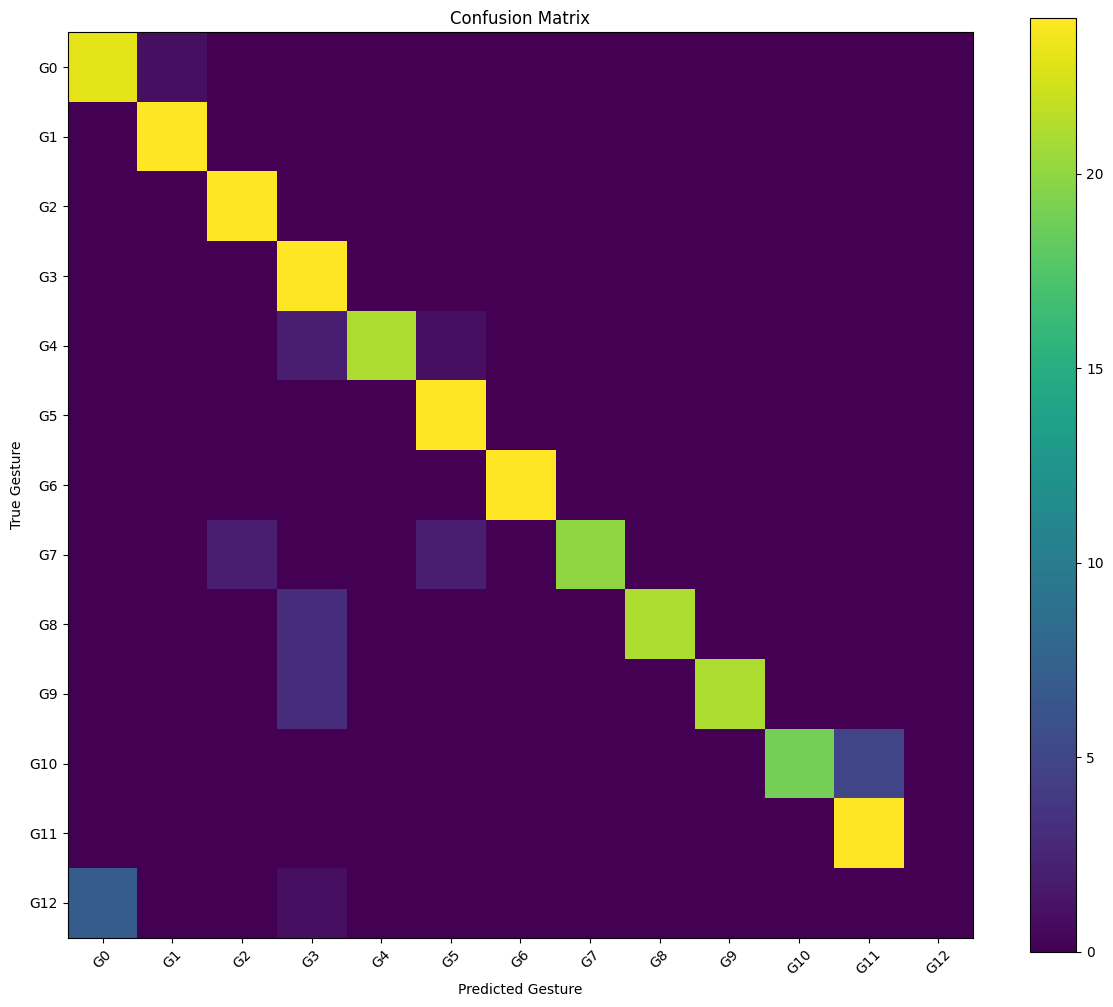

              precision    recall  f1-score   support

          G0       0.77      0.96      0.85        24
          G1       0.96      1.00      0.98        24
          G2       0.92      1.00      0.96        24
          G3       0.73      1.00      0.84        24
          G4       1.00      0.88      0.93        24
          G5       0.89      1.00      0.94        24
          G6       1.00      1.00      1.00        24
          G7       1.00      0.83      0.91        24
          G8       1.00      0.88      0.93        24
          G9       1.00      0.88      0.93        24
         G10       1.00      0.79      0.88        24
         G11       0.83      1.00      0.91        24
         G12       0.00      0.00      0.00         8

    accuracy                           0.91       296
   macro avg       0.85      0.86      0.85       296
weighted avg       0.90      0.91      0.90       296



/Users/louislecouturier/Desktop/HandGestureRecognition/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/louislecouturier/Desktop/HandGestureRecognition/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/louislecouturier/Desktop/HandGestureRecognition/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

In [14]:
evaluate_model()